In [ ]:
%pip install yfinance

In [ ]:
# Importamos as bibliotecas necessárias
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
base_treinamento = yf.download('WEGE3.SA', start="2023-01-01", end="2024-01-01", progress=False)['Close']
# Queremos remover eventuais valores nulos. Nessa base eles não são # muitos.
base_treinamento = base_treinamento.dropna()
#Vamos normalizar os valores para a faixa de 0 a 1. Isso ajuda no treinamento da rede.
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)


YF.download() has changed argument auto_adjust default to True


In [ ]:
previsores = []
preco_real = []
# Variamos i a partir de 90, pois esse é o tamanho da janela que    # estamos observando.
for i in range(90, 248):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real.append(base_treinamento_normalizada[i, 0])
# Transformamos os previsores e os preços reais em um array com formato correto para o treinamento na rede.
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [ ]:
# Adicionamos também camadas de Dropout para prevenir ovefitting
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))
regressor.add(Dense(units = 1, activation = 'linear'))
# Aqui definimos o otimizador, a função de perda e métricas de      # avaliação do modelo durante o treinamento.
regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Por fim, damos início ao treinamento. A taxa de aprendizado foi a padrão do otimizador,0.001.
regressor.fit(previsores, preco_real, epochs = 150, batch_size = 32)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 0.2071 - mean_absolute_error: 0.3823
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.0376 - mean_absolute_error: 0.1524
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0402 - mean_absolute_error: 0.1600
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0395 - mean_absolute_error: 0.1569
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.0349 - mean_absolute_error: 0.1503
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0330 - mean_absolute_error: 0.1378
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.0498 - mean_absolute_error: 0.1845
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - loss: 0.0312 - mean_absolute_error: 0.1392
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 0.0329 - mean_absolute_error: 0.1501
Epoch 10/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0373 - mean_absolute_error: 0.1495
Epoch 11/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
base_teste = yf.download('WEGE3.SA', start="2024-01-01", end="2024-06-01", progress=False)['Close']
# Queremos remover eventuais valores nulos. Nessa base eles não são # muitos.
base_teste = base_teste.dropna()
#Vamos normalizar os valores para a faixa de 0 a 1. Isso ajuda no treinamento da rede.
normalizador = MinMaxScaler(feature_range=(0,1))
base_teste_normalizada = normalizador.fit_transform(base_teste)

# Precisamos das últimas 90 entradas dos dados de treino para começar os testes. Então concatenamos as duas bases.
base_completa = pd.concat((base_treinamento, base_teste), axis = 0)
# Agora extraímos da base completa apenas a porção que precisamos e # aplicamos o mesmo normalizador.
entradas = base_completa[(len(base_treinamento)  - 90):].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

# Aplicamos a mesma estruturação e antes, separando de 90 em 90     # dias, movendo um dia por vez.
X_teste = []
for i in range(90, len(entradas)): # Adjust the range to start from 90
    X_teste.append(entradas[i-90:i, 0])

X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1)) # Now X_teste is 3D
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error

# Ajuste o índice para corresponder ao número de previsões
real = base_teste.values[len(base_teste) - len(previsoes):]

# Cálculo do MAE
mae = mean_absolute_error(real, previsoes)
print(f'Mean Absolute Error (MAE): {mae}')

Mean Absolute Error (MAE): 0.6562660107245812


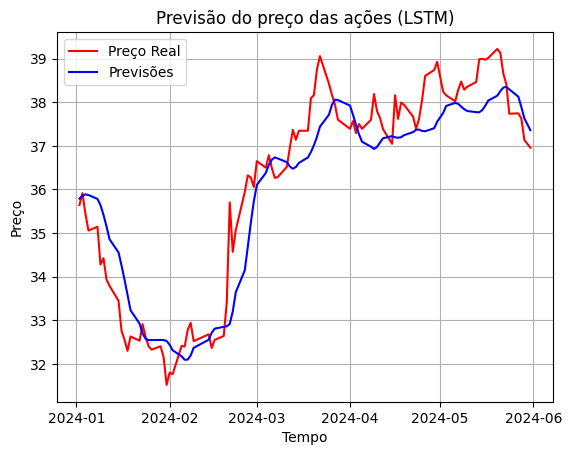

In [ ]:
plt.plot(base_teste.index, base_teste.values, color='red', label='Preço Real')
plt.plot(base_teste.index, previsoes, color='blue', label='Previsões')
plt.title('Previsão do preço das ações (LSTM)')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.grid(True)  # Adiciona grades padrão
plt.savefig('prev_weg.png')
plt.show()